In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import os
import re
import collections  # returns frequencies 

In [2]:
os.chdir(r'C:\Users\Owner\OneDrive\Research\Tech\DS_Projects\Other\Marketing\Kickstarter\Data')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
# Pull data coming in Funding Projects KS 
ks_proj2016 = pd.read_csv('ks-projects-201612.csv', encoding = "ISO-8859-1")
ks_proj2018 = pd.read_csv('ks-projects-201801.csv')
ks_proj2016.shape
ks_proj2018.shape
ks_proj2016.head()

C:\Users\Owner\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(323750, 17)

(378661, 15)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09 11:36:00,1000,2015-08-11 12:12:28,0,failed,0,GB,0,NaN,NaN,NaN,NaN
1,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26 00:20:50,45000,2013-01-12 00:20:50,220,failed,3,US,220,NaN,NaN,NaN,NaN
2,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16 04:24:11,5000,2012-03-17 03:24:11,1,failed,1,US,1,NaN,NaN,NaN,NaN
3,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29 01:00:00,19500,2015-07-04 08:35:03,1283,canceled,14,US,1283,NaN,NaN,NaN,NaN
4,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01 13:38:27,50000,2016-02-26 13:38:27,52375,successful,224,US,52375,NaN,NaN,NaN,NaN


In [4]:
pd.options.display.float_format = '{:.2f}'.format

In [11]:
# stripe out lead and trailing spaces from columns 
xcols = [x.strip() for x in ks_proj2016.columns]
ks_proj2016.columns = xcols
ks_proj2016.columns
ks_proj2016.dtypes

Index(['ID', 'name', 'category', 'main_category', 'currency', 'deadline',
       'goal', 'launched', 'pledged', 'state', 'backers', 'country',
       'usd pledged'],
      dtype='object')

ID                 int64
name              object
category          object
main_category     object
currency          object
deadline          object
goal             float64
launched          object
pledged          float64
state             object
backers          float64
country           object
usd pledged      float64
dtype: object

In [6]:
# Formating: convert goal, pledged, backers, and usd pledged to numbers 
ks_proj2016['goal'] = pd.to_numeric(ks_proj2016.goal, errors='coerce')
ks_proj2016['pledged'] = pd.to_numeric(ks_proj2016.pledged, errors='coerce')
ks_proj2016['usd pledged'] = pd.to_numeric(ks_proj2016['usd pledged'], errors='coerce')
ks_proj2016['backers'] = pd.to_numeric(ks_proj2016.backers, errors='coerce')
ks_proj2016[['goal','pledged','usd pledged','backers']].dtypes

goal           float64
pledged        float64
usd pledged    float64
backers        float64
dtype: object

In [8]:
# Columns "Unnamed 13" ... "Unnamed: 16" are due to data processing issue
    # Multiple rows where name mistakenly expanded out.  
len(ks_proj2016[ks_proj2016["Unnamed: 13"].notnull()])   # 625 / 320k rows affected. For simplicity will remove these rows.
ks_proj2016 = ks_proj2016[ks_proj2016["Unnamed: 13"].isnull()] # remove rows with extraneous values 
ks_proj2016.iloc[1450:1455,13:17].head()  # check on record 1454 (one of the affected columns) 

# remove Unnamed columns: no longer contain any numbers   
ks_proj2016 = ks_proj2016.drop(ks_proj2016.columns[13:17],axis=1)

625

,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
1450,NaN,NaN,NaN,nan
1451,NaN,NaN,NaN,nan
1452,NaN,NaN,NaN,nan
1453,NaN,NaN,NaN,nan
1455,NaN,NaN,NaN,nan


In [14]:
# Date Format 
ks_proj2016['deadline'] = pd.to_datetime(ks_proj2016.deadline, errors='coerce')
ks_proj2016.deadline.dtype
ks_proj2016['launched'] = pd.to_datetime(ks_proj2016.launched, errors='coerce')
lapsed = ks_proj2016.deadline - ks_proj2016.launched   # Time lapse between deadline and launch date 
lapsed.head() 

dtype('<M8[ns]')

0   58 days 23:23:32
1   45 days 00:00:00
2   30 days 01:00:00
3   55 days 16:24:57
4   35 days 00:00:00
dtype: timedelta64[ns]

In [15]:
# Get unique counts each dataset 
    # ks_proj2016 count 
print("ks2016", ks_proj2016.nunique(axis=0)) 

ks2016 ID               323125
name             321009
category            165
main_category        15
currency             15
deadline         294796
goal               7562
launched         322633
pledged           54974
state                11
backers            3583
country              23
usd pledged       94360
dtype: int64


In [16]:
#---- RESPONSE Varibles: Proessing 
    # Candidate variables: 1. no. of backers  2. Status (failed or not: 0 or 1), 3. avg. pledge by backer 4. pledgevgoal 
        # avg plegdge: if backers = 0, set value to 0 
avg_pledge = np.where(ks_proj2016['backers']==0, 0, ks_proj2016['usd pledged'] / ks_proj2016['backers'])
stats.describe(avg_pledge)
ks_proj2016["avg_pledge"] = avg_pledge 

DescribeResult(nobs=323125, minmax=(nan, nan), mean=nan, variance=nan, skewness=nan, kurtosis=nan)

In [17]:
        # pledged vs. goal 
print("usd pledge is null", len(ks_proj2016[ks_proj2016["usd pledged"].isnull()]))  # null numerator
print("num goal is null", len(ks_proj2016[ks_proj2016["goal"].isnull()]))
pledgedvgoal = np.where(ks_proj2016["usd pledged"].isnull(), 0, ks_proj2016['usd pledged'] / ks_proj2016['goal'])
stats.describe(pledgedvgoal)  # many N/A's.    
print("median of pledgedvgoal", np.percentile(pledgedvgoal, 50))
ks_proj2016["pledgedvgoal"] = pledgedvgoal
ks_proj2016.goal.describe()
pledgedvgoal[0:5]

usd pledge is null 3797
num goal is null 7


DescribeResult(nobs=323125, minmax=(0.0, 55266.57), mean=2.610217814872047, variance=30920.224751350874, skewness=190.13349245746394, kurtosis=46356.56195746872)

median of pledgedvgoal 0.1043285936


count      323118.00
mean        47152.52
std       1139577.48
min             0.01
25%          2000.00
50%          5000.00
75%         15000.00
max     100000000.00
Name: goal, dtype: float64

array([0.00000000e+00, 4.88888889e-03, 2.00000000e-04, 6.57948718e-02,
       1.04750000e+00])

In [18]:
    # Status: State value counts 
ks_proj2016.state.value_counts()

failed        168221
successful    113081
canceled       32354
live            4428
undefined       3555
suspended       1479
0                  3
2503               1
6323               1
7470               1
3280               1
Name: state, dtype: int64

In [19]:
    # State: create field "Status" 
        # remove live, undefined, and those with numbers .
ks_proj2016 = ks_proj2016[ks_proj2016['state'].isin(['failed','successful','canceled','suspended','undefined'])]
len(ks_proj2016)

318690

In [20]:
# State: Evaluate which states to keep 
print("stats for canceled")
ks_proj2016.pledgedvgoal[ks_proj2016['state']=='canceled'].describe()  # median close to 0 with massive outliers 
print("stats for suspended")
ks_proj2016.pledgedvgoal[ks_proj2016['state']=='suspended'].describe()  # designate as fail
print("stats for undefined")
ks_proj2016.pledgedvgoal[ks_proj2016['state']=='undefined'].describe()  # all zeroes: remove  
ks_proj2016 = ks_proj2016[ks_proj2016['state'].isin(['failed','successful','canceled','suspended'])]

stats for canceled


count   32354.00
mean        1.42
std       118.73
min         0.00
25%         0.00
50%         0.01
75%         0.08
max     16283.38
Name: pledgedvgoal, dtype: float64

stats for suspended


count   1479.00
mean       1.52
std       17.80
min        0.00
25%        0.00
50%        0.01
75%        0.25
max      560.40
Name: pledgedvgoal, dtype: float64

stats for undefined


count   3555.00
mean       0.00
std        0.00
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        0.00
Name: pledgedvgoal, dtype: float64

In [28]:
# --- RESPONSE Variable Status: Designate 'successful' as 1, everything else as 0
status = np.where(ks_proj2016['state'] == 'successful', 1, 0)
collections.Counter(status)
    # add Status to datafreame 
ks_proj2016['outcome'] = status

Counter({0: 202054, 1: 113081})

In [ ]:
# Launch month Analysis : Create Field
launch_month = ks_proj2016['launched'].dt.month
ks_proj2016['launch_month'] = launch_month

outcome,0,1,success_perc
launch_month,,,
1,15015,7859,0.34
2,15766,9500,0.38
3,17491,10792,0.38
4,17099,10444,0.38
5,17520,10298,0.37
6,17718,10128,0.36
7,21635,10178,0.32
8,18377,9212,0.33
9,16992,9636,0.36


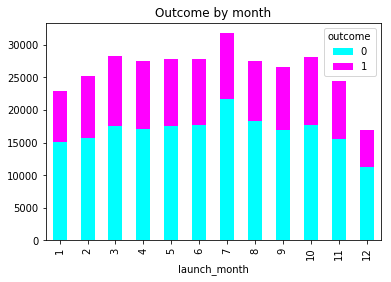

In [52]:
# Launch month: find average outcome: success/failure
launch_pivot = pd.pivot_table(ks_proj2016, index='launch_month',values='outcome', aggfunc=np.mean)
launch_outcome = pd.crosstab(ks_proj2016.launch_month, ks_proj2016.outcome)
launch_outcome['success_perc'] = launch_pivot.outcome
launch_outcome[launch_outcome.columns[0:2]].plot(kind='bar', 
            stacked=True, color=['cyan', 'magenta'], grid=False, title='Outcome by month')
launch_outcome

In [ ]:
# launch month: see average pledge 
launch_pivot_ap = pd.pivot_table(ks_proj2016, index='launch_month',values='avg_pledge', aggfunc=np.mean)
sns.barplot(x='avg_pledge', y = 'launch_month', 
            data=launch_pivot_ap).set_title("Average Pledge/Backer by Launch Month")
launch_pivot_ap